In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
data = pd.read_csv('processed_data_by_property.csv')

In [127]:
target = 'PRICE'

In [128]:
# Define features
categorical_features = ['TYPE', 'ZIPCODE', 'BOROUGH']
numeric_features = [
    'BEDS', 'BATH', 'PROPERTYSQFT', 'Population', 'LivelinessScore', 'LATITUDE', 'LONGITUDE', 'MedianHouseholdIncome', 'PopulationDensity']

In [129]:
X = data.drop(columns=[target])
y = data[target]

In [130]:
# Preprocessor: Scale numeric features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [131]:
# Define the Random Forest model pipeline
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [133]:
# Train the model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BEDS', 'BATH',
                                                   'PROPERTYSQFT', 'Population',
                                                   'LivelinessScore',
                                                   'LATITUDE', 'LONGITUDE',
                                                   'MedianHouseholdIncome',
                                                   'PopulationDensity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TYPE', 'ZIPCODE', 'BOROUGH',
                                                   'Neighborhood'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [134]:
# Calculate performance metrics for the model
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [135]:
# Training set metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

# Test set metrics
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Calculate MAE as a percentage
avg_train_price = y_train.mean()
avg_test_price = y_test.mean()
train_mae_percent = (train_mae / avg_train_price) * 100
test_mae_percent = (test_mae / avg_test_price) * 100

In [136]:
# Print metrics
print("Training Set Metrics:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MAE: ${train_mae:,.2f} ({train_mae_percent:.2f}%)")
print(f"RMSE: ${train_rmse:,.2f}")
print(f"MAPE: {train_mape:.2f}%")

Training Set Metrics:
R2 Score: 0.9663
MAE: $73,360.16 (7.95%)
RMSE: $116,532.85
MAPE: 8.92%


In [137]:
print("\nTest Set Metrics:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MAE: ${test_mae:,.2f} ({test_mae_percent:.2f}%)")
print(f"RMSE: ${test_rmse:,.2f}")
print(f"MAPE: {test_mape:.2f}%")


Test Set Metrics:
R2 Score: 0.7400
MAE: $197,936.82 (22.57%)
RMSE: $317,556.87
MAPE: 24.37%


In [138]:
# Save the model
joblib.dump(rf_model, 'rf_model_features.joblib')

['rf_model_features.joblib']

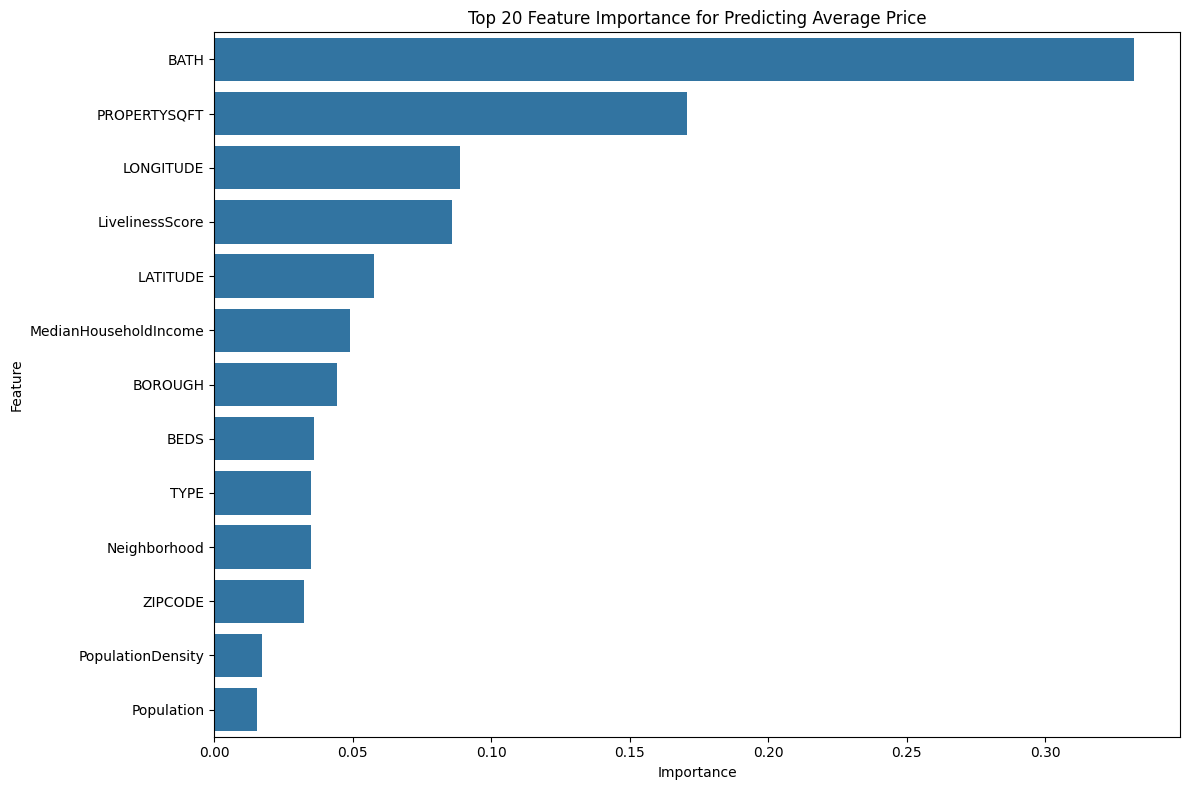

In [139]:
# Get feature names
numeric_features_names = numeric_features
categorical_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.array(numeric_features_names + list(categorical_features_names))

# Get feature importances from the XGBoost model
importances = rf_model.named_steps['regressor'].feature_importances_

# Aggregate importances for categorical variables
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance['feature'] = feature_importance['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
feature_importance = feature_importance.groupby('feature').sum().reset_index()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Plot top 20 feature importances
top_n = 20
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.title('Top 20 Feature Importance for Predicting Average Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()